In [1]:
source_prompt = "a bowl of fruits"
target_prompt = "a bowl of pears"

In [2]:
import torch
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline

pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16,
    safety_checker=None,
    use_safetensors=True,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


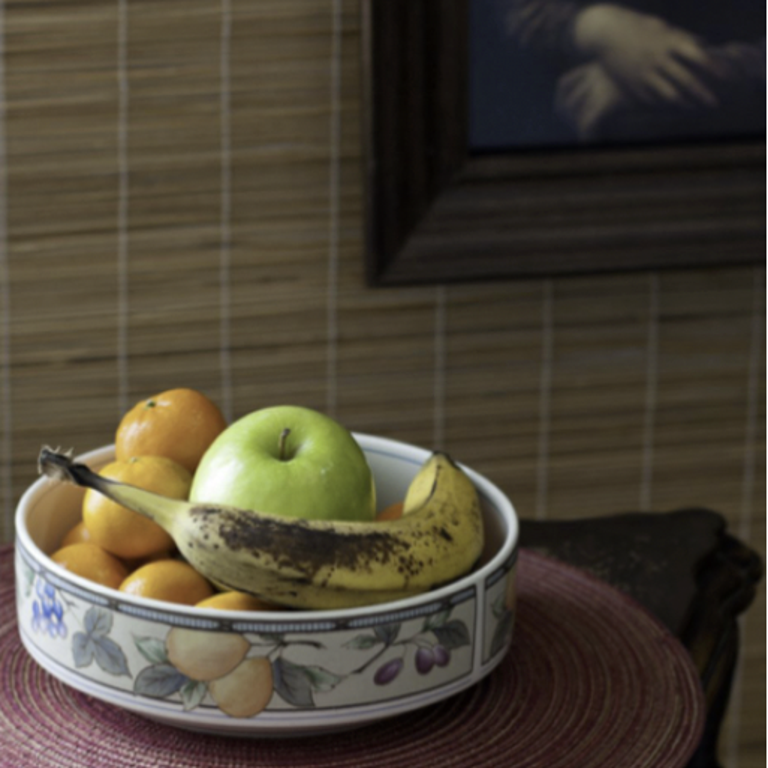

In [3]:
from diffusers.utils import load_image, make_image_grid

img_url = "https://github.com/Xiang-cd/DiffEdit-stable-diffusion/raw/main/assets/origin.png"
raw_image = load_image(img_url).resize((768, 768))
raw_image

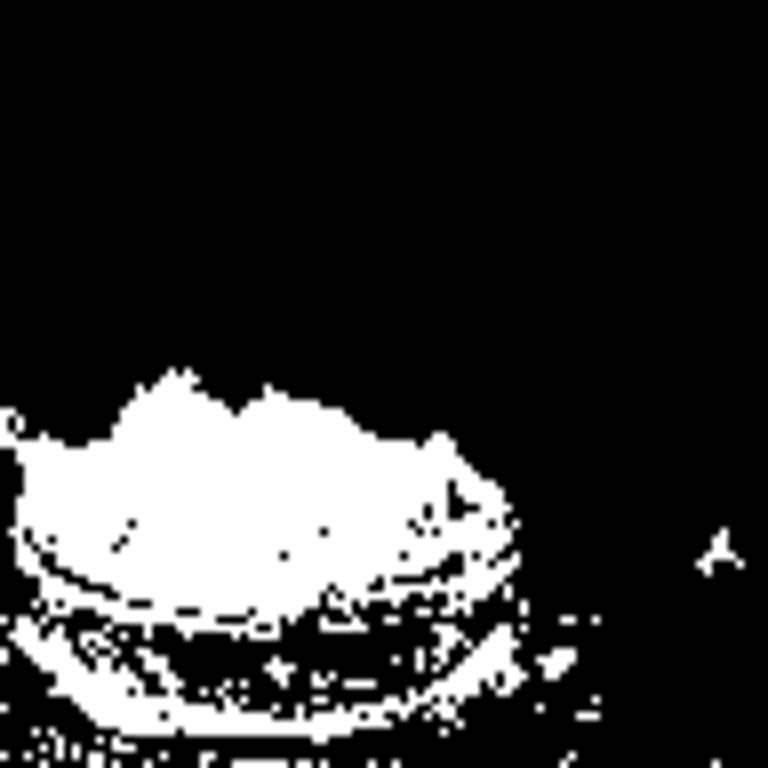

In [4]:
from PIL import Image

source_prompt = "a bowl of fruits"
target_prompt = "a basket of pears"
mask_image = pipeline.generate_mask(
    image=raw_image,
    source_prompt=source_prompt,
    target_prompt=target_prompt,
)
Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))

In [5]:
inv_latents = pipeline.invert(prompt=source_prompt, image=raw_image).latents

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

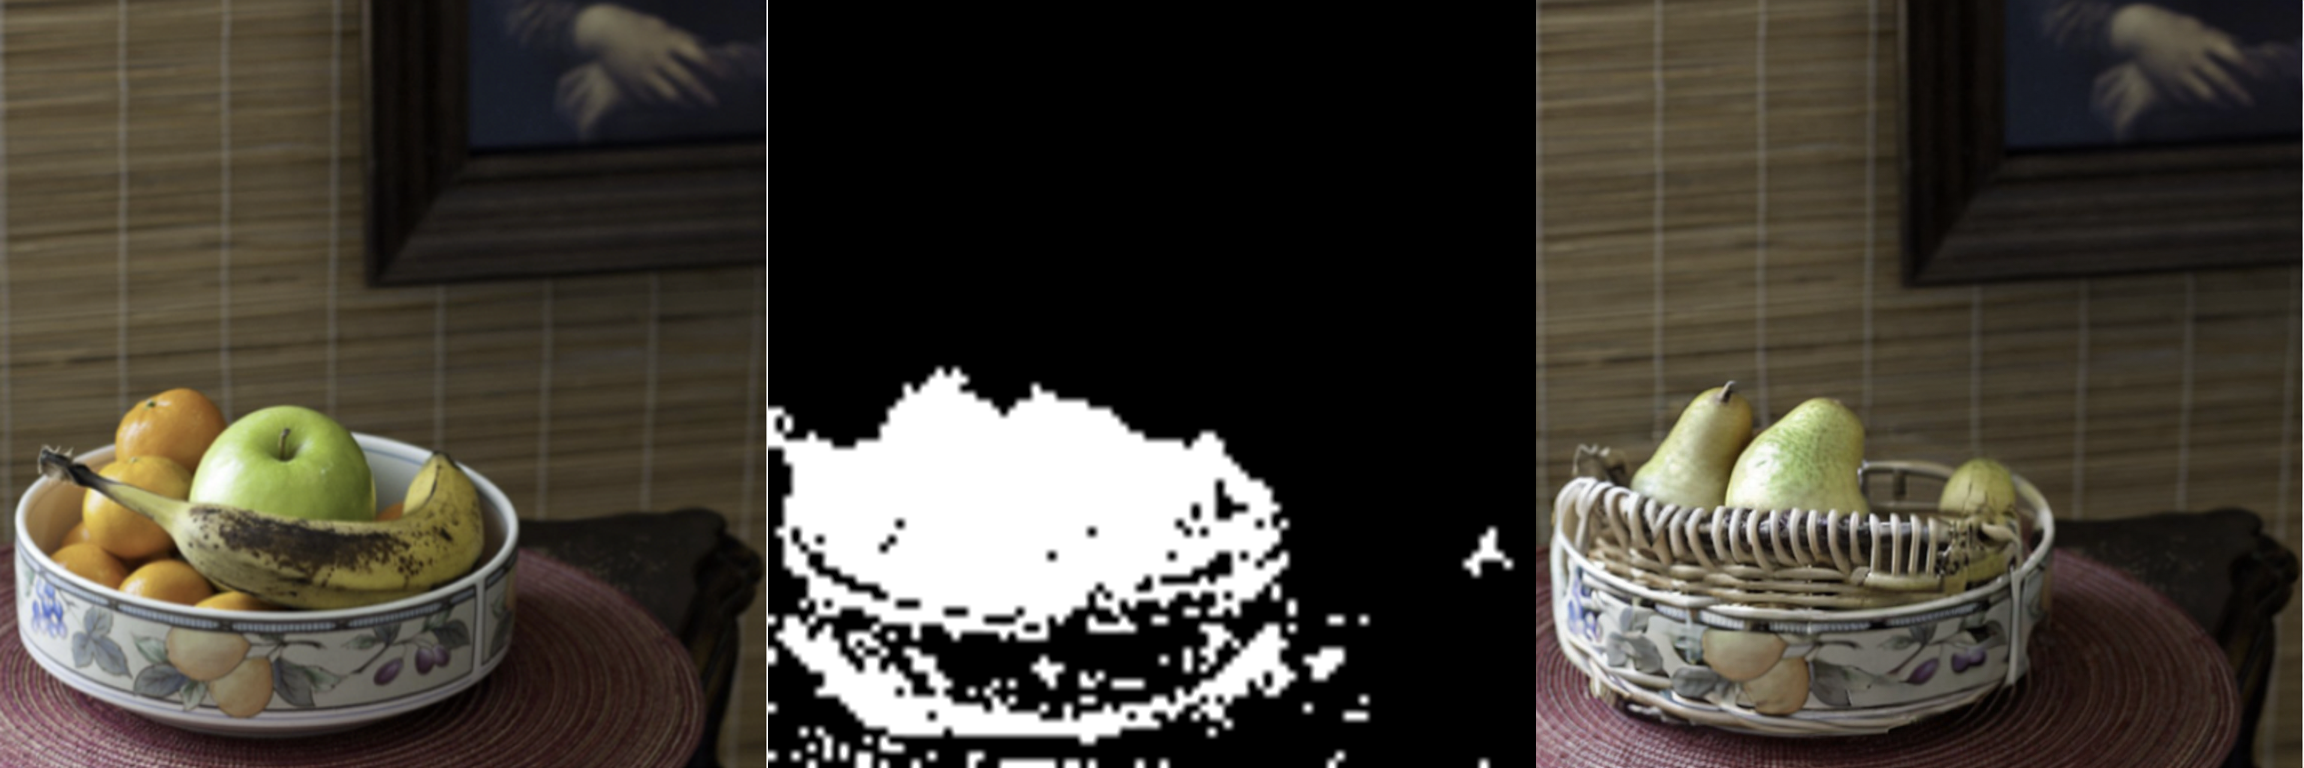

In [6]:
output_image = pipeline(
    prompt=target_prompt,
    mask_image=mask_image,
    image_latents=inv_latents,
    negative_prompt=source_prompt,
).images[0]
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)

## Inpainting

Source: https://huggingface.co/docs/diffusers/using-diffusers/inpaint

In [7]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
# pipeline.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

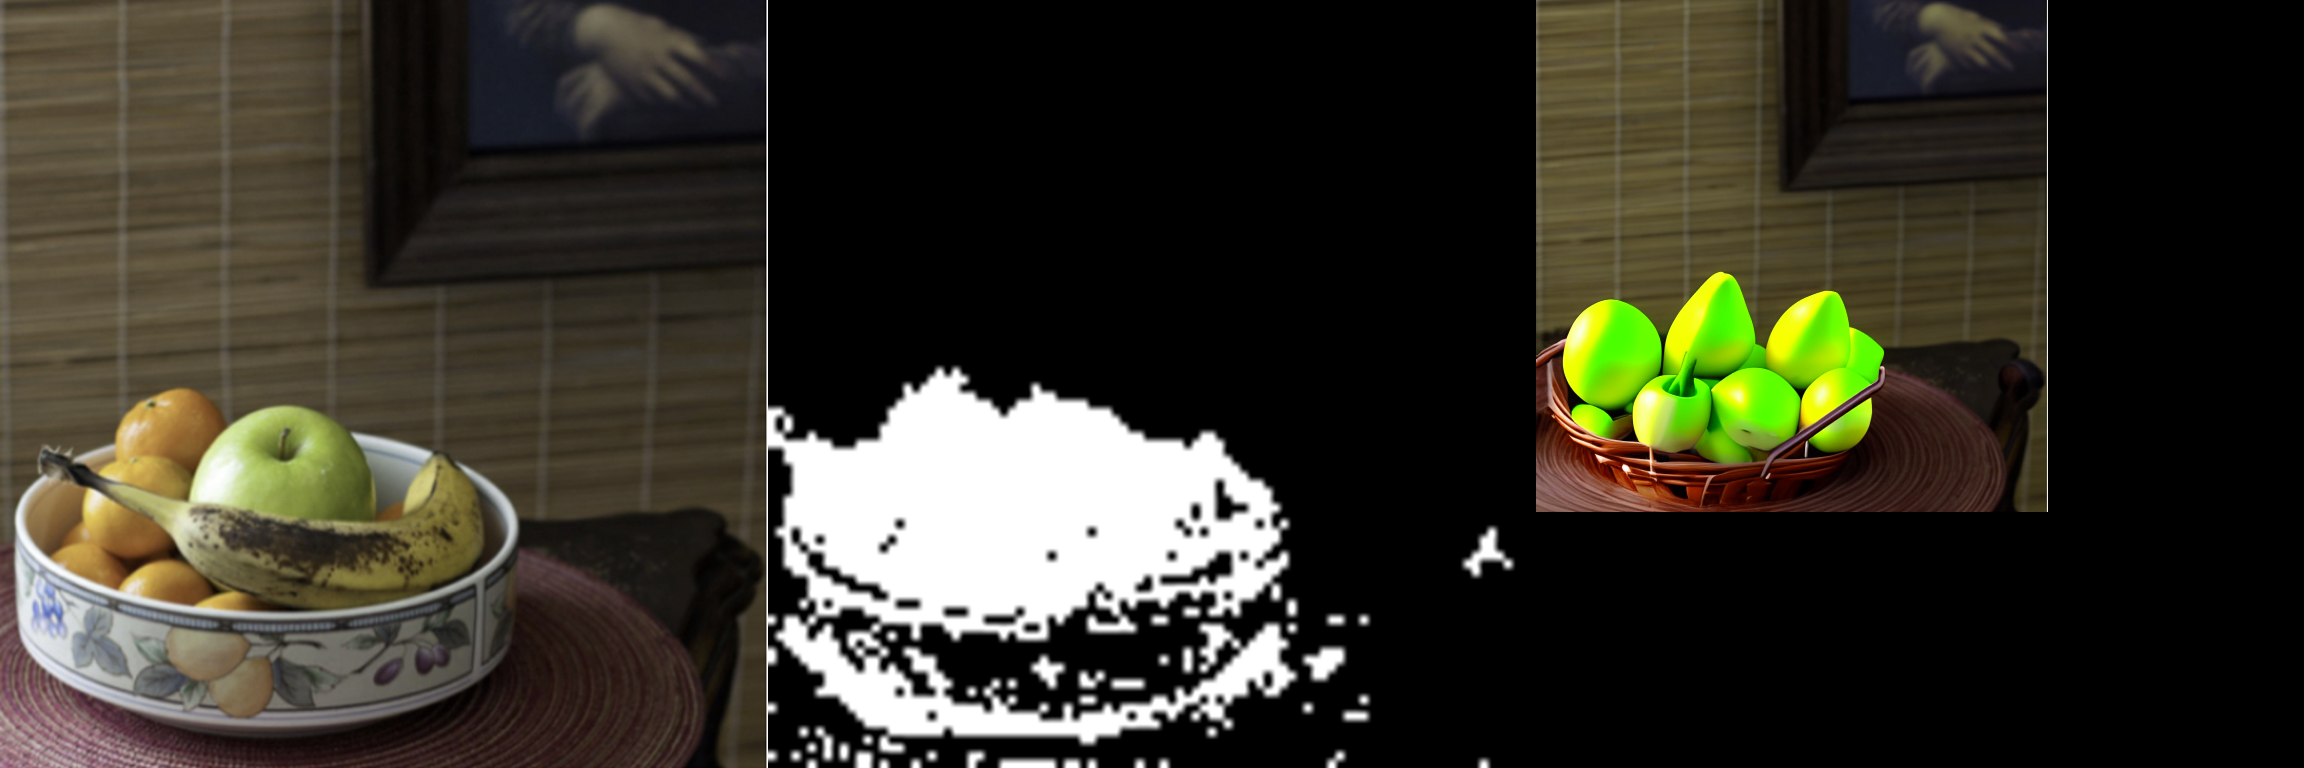

In [8]:
# prompt = "a black cat with glowing eyes, cute, adorable, disney, pixar, highly detailed, 8k"
# negative_prompt = "bad anatomy, deformed, ugly, disfigured"
prompt = "a basket of pears"
negative_prompt = "discolored, deformed, disfigured"
output_image = pipeline(prompt=prompt, negative_prompt=negative_prompt, image=raw_image, mask_image=mask_image).images[0]
# make_image_grid([init_image, mask_image, image], rows=1, cols=3)
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)

## Generate embeddings using `Flan-T5`

In [14]:
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

tokenizer_config.json: 100%|██████████| 2.54k/2.54k [00:00<00:00, 4.89MB/s]
spiece.model: 100%|██████████| 792k/792k [00:00<00:00, 8.51MB/s]
tokenizer.json: 100%|██████████| 2.42M/2.42M [00:00<00:00, 4.48MB/s]
special_tokens_map.json: 100%|██████████| 2.20k/2.20k [00:00<00:00, 26.0MB/s]
config.json: 100%|██████████| 662/662 [00:00<00:00, 1.31MB/s]
model.safetensors: 100%|██████████| 3.13G/3.13G [00:58<00:00, 53.7MB/s]
generation_config.json: 100%|██████████| 147/147 [00:00<00:00, 231kB/s]


In [15]:
source_concept = "bowl"
target_concept = "basket"

source_text = f"Provide a caption for images containing a {source_concept}. "
"The captions should be in English and should be no longer than 150 characters."

target_text = f"Provide a caption for images containing a {target_concept}. "
"The captions should be in English and should be no longer than 150 characters."

'The captions should be in English and should be no longer than 150 characters.'

In [16]:
@torch.no_grad()
def generate_prompts(input_prompt):
    input_ids = tokenizer(input_prompt, return_tensors="pt").input_ids.to("cuda")

    outputs = model.generate(
        input_ids, temperature=0.8, num_return_sequences=16, do_sample=True, max_new_tokens=128, top_k=10
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

source_prompts = generate_prompts(source_text)
target_prompts = generate_prompts(target_text)
print(source_prompts)
print(target_prompts)

['A bowl of soup with carrots in the middle.', 'A bowl of ice cream', 'A bowl with a ring around it.', 'A bowl with a lot of food.', 'a bowl of ice', 'The bowl of food is covered with a tupperware.', 'a bowl of water and a bowl of food', 'A white bowl filled with a red berry.', 'A bowl of food.', 'a bowl of soup', 'bowls of ice cream', 'bowl with red flowers', 'A small bowl of pasta in a small dish.', 'a bowl of soup', 'A bowl on a pier with a crow in the background', 'a bowl of food']
['A couple are holding a basket.', 'A man is preparing to sell a basket.', 'Two people in a basket.', 'A basket of fruits in a grocery store.', 'An orange basket with a basket and fruits next to it.', 'A woman is holding a basket full of berries, which she is holding.', 'The basket is a gift for someone.', 'The basket is filled with fruit.', 'The basket is a gift from the woman.', 'An oversized basket of fruit on a table.', 'a white basket with a red flower', 'This image shows a basket full of flowers in

In [17]:
pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()


def embed_prompts(sentences, tokenizer, text_encoder, device="cuda"):
    embeddings = []
    for sent in sentences:
        text_inputs = tokenizer(
            sent,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(text_input_ids.to(device), attention_mask=None)[0]
        embeddings.append(prompt_embeds)
    return torch.concatenate(embeddings, dim=0).mean(dim=0).unsqueeze(0)

source_embeds = embed_prompts(source_prompts, pipeline.tokenizer, pipeline.text_encoder)
target_embeds = embed_prompts(target_prompts, pipeline.tokenizer, pipeline.text_encoder)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 14.82it/s]


The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
100%|██████████| 40/40 [00:02<00:00, 17.99it/s]


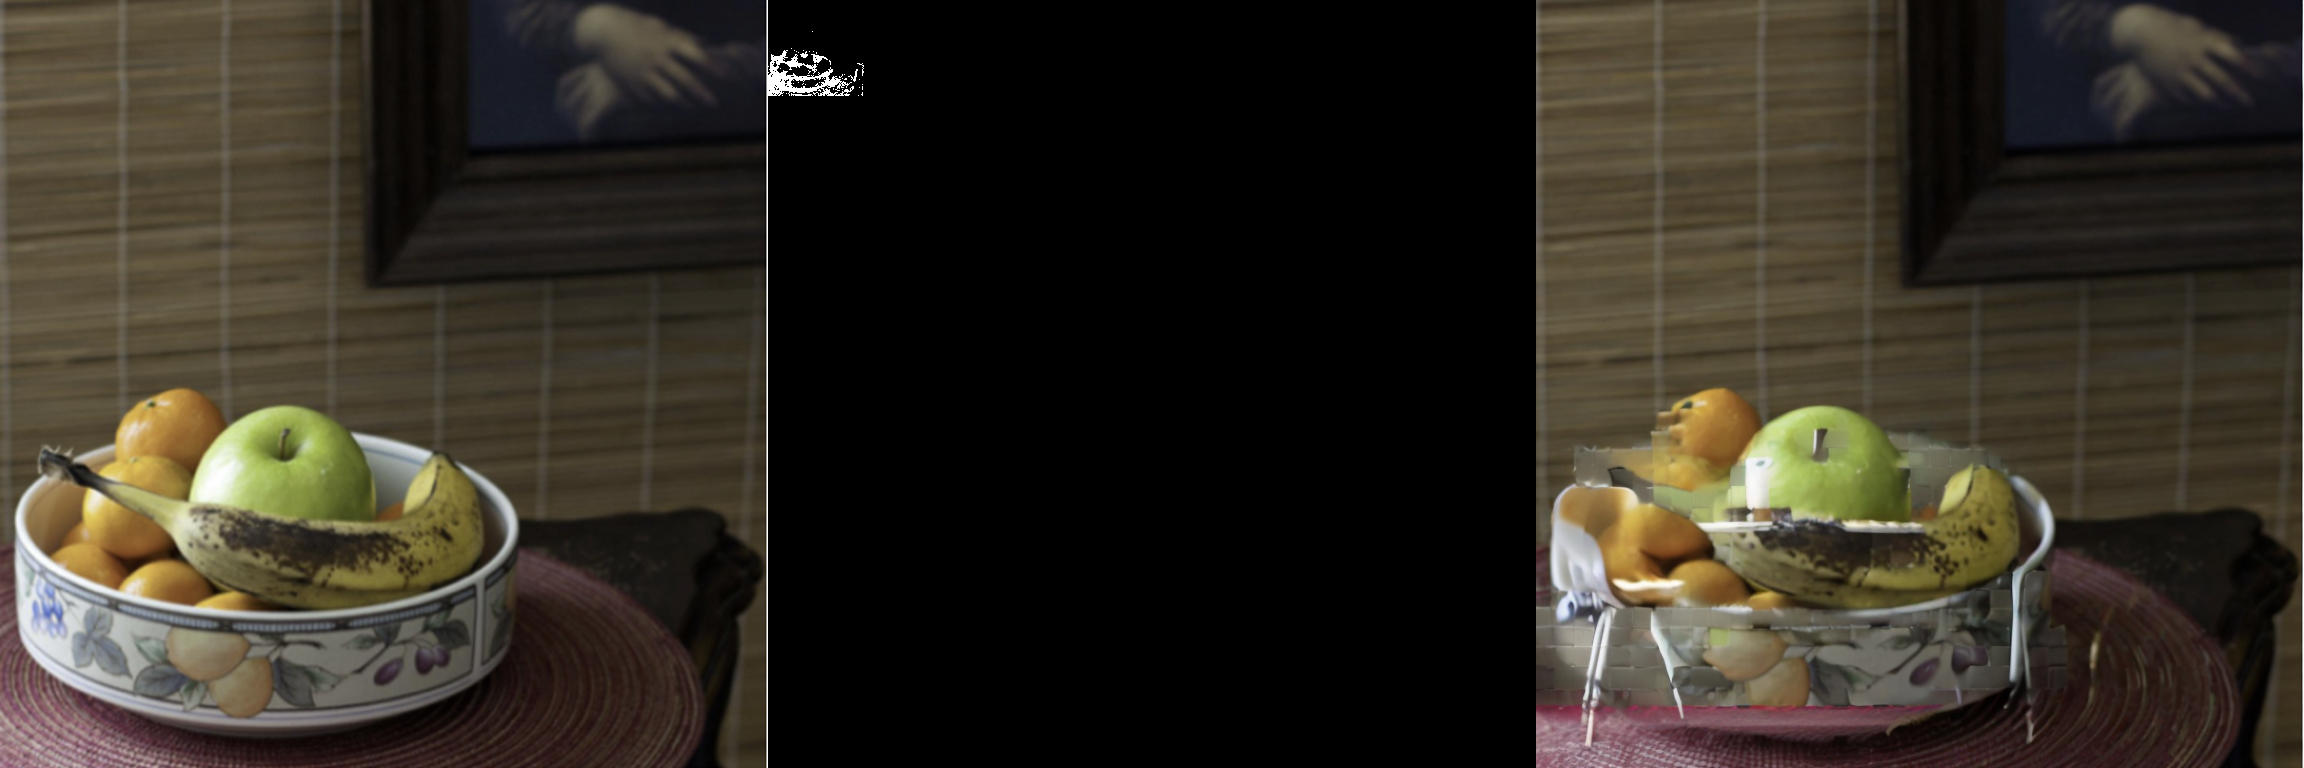

In [18]:
from diffusers import DDIMInverseScheduler, DDIMScheduler
from diffusers.utils import load_image, make_image_grid
from PIL import Image

pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)

img_url = "https://github.com/Xiang-cd/DiffEdit-stable-diffusion/raw/main/assets/origin.png"
raw_image = load_image(img_url).resize((768, 768))

mask_image = pipeline.generate_mask(
    image=raw_image,
# -     source_prompt=source_prompt,
# -     target_prompt=target_prompt,
    source_prompt_embeds=source_embeds,
    target_prompt_embeds=target_embeds,
)

inv_latents = pipeline.invert(
# -     prompt=source_prompt,
    prompt_embeds=source_embeds,
    image=raw_image,
).latents

output_image = pipeline(
    mask_image=mask_image,
    image_latents=inv_latents,
# -     prompt=target_prompt,
# -     negative_prompt=source_prompt,
    prompt_embeds=target_embeds,
    negative_prompt_embeds=source_embeds,
).images[0]
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L")
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)